In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Seed for reproducibility
np.random.seed(42)

# Simulate 10 independent variables
n_samples = 1000
data = {
    'Credit_Score': np.random.normal(650, 50, n_samples),
    'Income': np.random.normal(50000, 15000, n_samples),
    'Debt_to_Income': np.random.uniform(0.1, 0.6, n_samples),
    'Age': np.random.normal(35, 10, n_samples),
    'Employment_Years': np.random.randint(0, 30, n_samples),
    'Loan_Amount': np.random.normal(15000, 5000, n_samples),
    'Num_Open_Credit_Lines': np.random.randint(1, 10, n_samples),
    'Credit_Utilization': np.random.uniform(0.1, 0.9, n_samples),
    'Delinquencies_Last2Years': np.random.poisson(1, n_samples),
    'Public_Records': np.random.poisson(0.2, n_samples)
}

# Dependent variable: Probability of default
# Credit_Score and Income negatively related to default; Debt/Utilization increase risk
linear_combination = (-0.005 * data['Credit_Score'] +
                      -0.00002 * data['Income'] +
                      3 * data['Debt_to_Income'] +
                      2 * data['Credit_Utilization'] +
                      0.5 * data['Delinquencies_Last2Years'] +
                      0.7 * data['Public_Records'] +
                      np.random.normal(0, 0.5, n_samples))

# Sigmoid to get probabilities
prob_default = 1 / (1 + np.exp(-linear_combination))

# Binary target variable (Default: 0 or 1)
data['Default'] = (prob_default > 0.5).astype(int)

df = pd.DataFrame(data)

df.head()


,Credit_Score,Income,Debt_to_Income,Age,Employment_Years,Loan_Amount,Num_Open_Credit_Lines,Credit_Utilization,Delinquencies_Last2Years,Public_Records,Default
0,674.835708,70990.331549,0.303553,40.731278,0,24771.486190,9,0.359687,0,0,0
1,643.086785,63869.505244,0.133005,17.141335,3,21223.263908,9,0.676927,2,1,0
2,682.384427,50894.455549,0.274410,31.403703,9,15154.627089,2,0.626231,0,1,0
3,726.151493,40295.948334,0.155499,38.011073,10,12844.265584,6,0.867290,1,0,0
4,638.292331,60473.349704,0.504118,36.838345,16,20475.294332,4,0.844872,1,0,1


In [5]:
X = df.drop('Default', axis=1)
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]


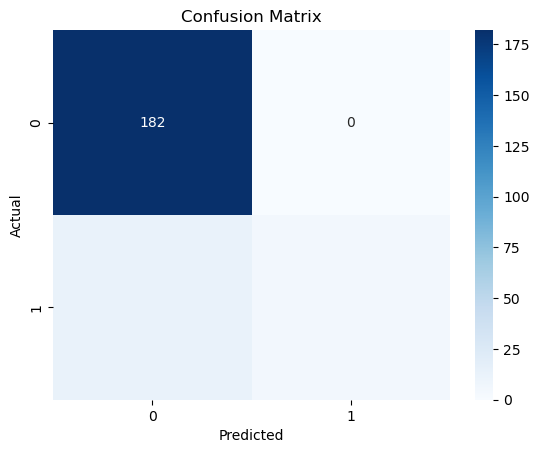

              precision    recall  f1-score   support

           0       0.93      1.00      0.97       182
           1       1.00      0.28      0.43        18

    accuracy                           0.94       200
   macro avg       0.97      0.64      0.70       200
weighted avg       0.94      0.94      0.92       200

ROC AUC Score: 0.9469


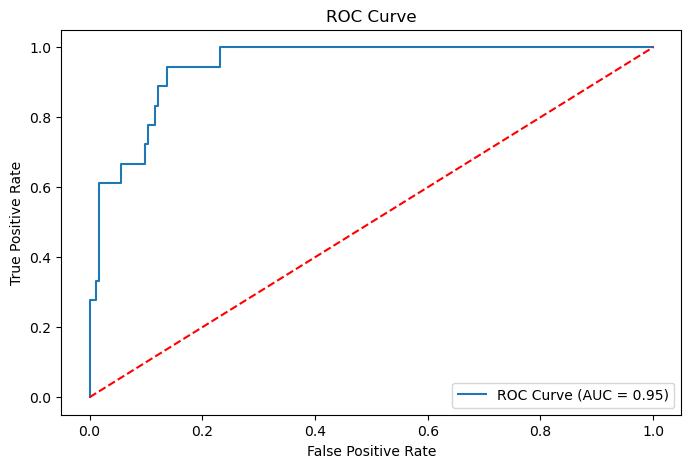

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


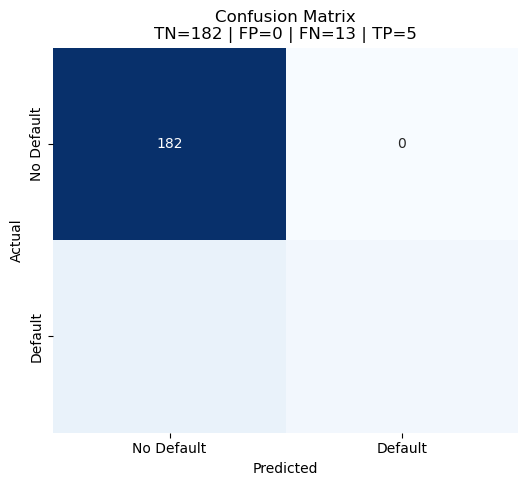

True Negatives (TN): 182
False Positives (FP): 0
False Negatives (FN): 13
True Positives (TP): 5


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix values
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Display matrix with labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nTN={tn} | FP={fp} | FN={fn} | TP={tp}')
plt.show()

# Print counts separately
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

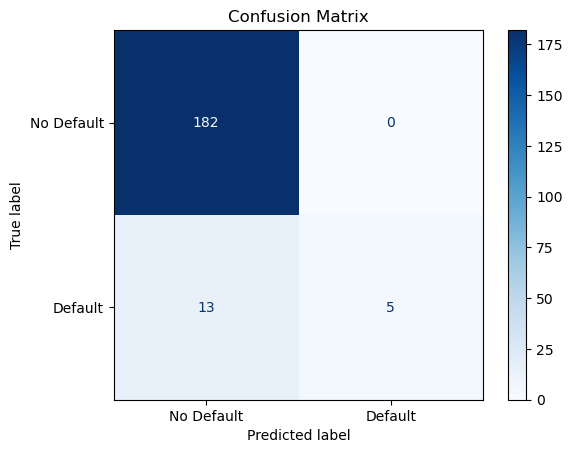

In [11]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['No Default', 'Default'], cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [8]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
})

coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient'])

coef_df.sort_values(by='Odds Ratio', ascending=False)


,Feature,Coefficient,Odds Ratio
8,Delinquencies_Last2Years,1.032871,2.809118
9,Public_Records,0.733790,2.082959
7,Credit_Utilization,0.521867,1.685170
2,Debt_to_Income,0.260665,1.297793
3,Age,0.011031,1.011092
4,Employment_Years,0.005190,1.005203
5,Loan_Amount,0.000024,1.000024
1,Income,-0.000044,0.999956
0,Credit_Score,-0.004637,0.995373
6,Num_Open_Credit_Lines,-0.101187,0.903764


In [9]:
# Add constant for intercept
X_train_const = sm.add_constant(X_train)

# Fit with statsmodels
logit_model = sm.Logit(y_train, X_train_const).fit()

# Summary with p-values
logit_model.summary()


Optimization terminated successfully.
         Current function value: 0.113925
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                  800
Model:                          Logit   Df Residuals:                      789
Method:                           MLE   Df Model:                           10
Date:                Thu, 15 May 2025   Pseudo R-squ.:                  0.5450
Time:                        14:38:34   Log-Likelihood:                -91.140
converged:                       True   LL-Null:                       -200.31
Covariance Type:            nonrobust   LLR p-value:                 2.367e-41
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -3.9697      3.169     -1.253      0.210     -10.181       2.241
Credit_Score                -0.0139      0.004     -3.133      0.002      -0.023      -0.005
Income                   -6.636e-05   1.49e-05     -4.443      0.000   -9.56e-05   -3.71e-05
Debt_to_Income              11.1891      1.926      5.810      0.000       7.414      14.964
Age                         -0.0163      0.018     -0.917      0.359      -0.051       0.019
Employment_Years             0.0118      0.024      0.487      0.627      -0.036       0.059
Loan_Amount               2.479e-05   4.28e-05      0.578      0.563   -5.92e-05       0.000
Num_Open_Credit_Lines        0.0809      0.074      1.091      0.275      -0.065       0.226
Credit_Utilization           8.0444      1.328      6.059      0.000       5.442      10.647
Delinquencies_Last2Years     1.7212      0.234      7.346      0.000       1.262       2.180
Public_Records               2.7809      0.428      6.501      0.000       1.943       3.619
============================================================================================

Possibly complete quasi-separation: A fraction 0.16 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""